Version 1.0.0

# Introduction

In this programming assignment we will illustrate a very severe data leakage, that can often be found in competitions, where the pairs of object should be scored, e.g. predict $1$ if two objects belong to the same class and $0$ otherwise. 

The data in this assignment is taken from a real competition, and the funniest thing is that *we will not use training set at all* and achieve almost 100% accuracy score! We will just exploit the leakage.

Now go through the notebook and complete the assignment.

In [1]:
import numpy as np
import pandas as pd 
import scipy.sparse

# Load the data

Let's load the test data. Note, that we don't have any training data here, just test data. Moreover, *we will not even use any features* of test objects. All we need to solve this task is the file with the indices for the pairs, that we need to compare.

Let's load the data with test indices.

In [2]:
test = pd.read_csv('../readonly/data_leakages_data/test_pairs.csv')
test.head(10)

,pairId,FirstId,SecondId
0,0,1427,8053
1,1,17044,7681
2,2,19237,20966
3,3,8005,20765
4,4,16837,599
5,5,3657,12504
6,6,2836,7582
7,7,6136,6111
8,8,23295,9817
9,9,6621,7672


For example, we can think that there is a test dataset of images, and each image is assigned a unique `Id` from $0$ to $N-1$ (N -- is the number of images). In the dataframe from above `FirstId` and `SecondId` point to these `Id`'s and define pairs, that we should compare: e.g. do both images in the pair belong to the same class or not. So, for example for the first row: if images with `Id=1427` and `Id=8053` belong to the same class, we should predict $1$, and $0$ otherwise. 

But in our case we don't really care about the images, and how exactly we compare the images (as long as comparator is binary).  

**We suggest you to try to solve the puzzle yourself first.** You need to submit a `.csv` file with columns `pairId` and `Prediction` to the grader. The number of submissions allowed is made pretty huge to let you explore the data without worries. The returned score should be very close to $1$.

**If you do not want to think much** -- scroll down and follow the instructions below.

## TRY FIRST WITHOUT FOLLOWING INSTRUCTION!

### Got passed without following instruction
### Note.

Firstly I draw a scatter plot for `test['FirstId']` and `test['SecondId']`. Then I found that there exist two of patterns.<br>

* **First pattern** - many of scattered lines (above `y = x` line)
* **Second pattern** - scattered points consisting of a form of rectangle

Since the rectangle showing second pattern has about half size of the entire data points, I assummed that first pattern will have target label = 1 and the second pattern will have target label = 0.<br>

So I processed the data and tried to divide the data according to my assumption.<br>

Firstly I extract rows that values of `test['SecondId']` are bigger than  `test['FirstId']`.<br>

Secondly I generated a column that subtract 'FirstId' column from 'SecondId' column, and calculate the number of unique values. Since the sample showing second pattern has common value for ('SecondId' - 'FirstId') - because they form a kind of direct lines - sample for second pattern may have lots of unique value counts like more than 10 or 100 or something.<br>

So I tried some threshold test and I got 0.983354 for threshold = 16, which is over the pass score.

In [3]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 368550 entries, 0 to 368549
Data columns (total 3 columns):
pairId      368550 non-null int64
FirstId     368550 non-null int64
SecondId    368550 non-null int64
dtypes: int64(3)
memory usage: 8.4 MB


In [4]:
test.nunique()

pairId      368550
FirstId      26325
SecondId     26310
dtype: int64

In [8]:
len((test['FirstId'] - test['SecondId']).unique())

36602

In [9]:
len((test['FirstId'] - test['SecondId']).apply(lambda x: abs(x)).unique())

24728

In [10]:
test['FirstId'].min(), test['FirstId'].max()

(0, 26324)

In [11]:
test['SecondId'].min(), test['SecondId'].max()

(0, 26324)

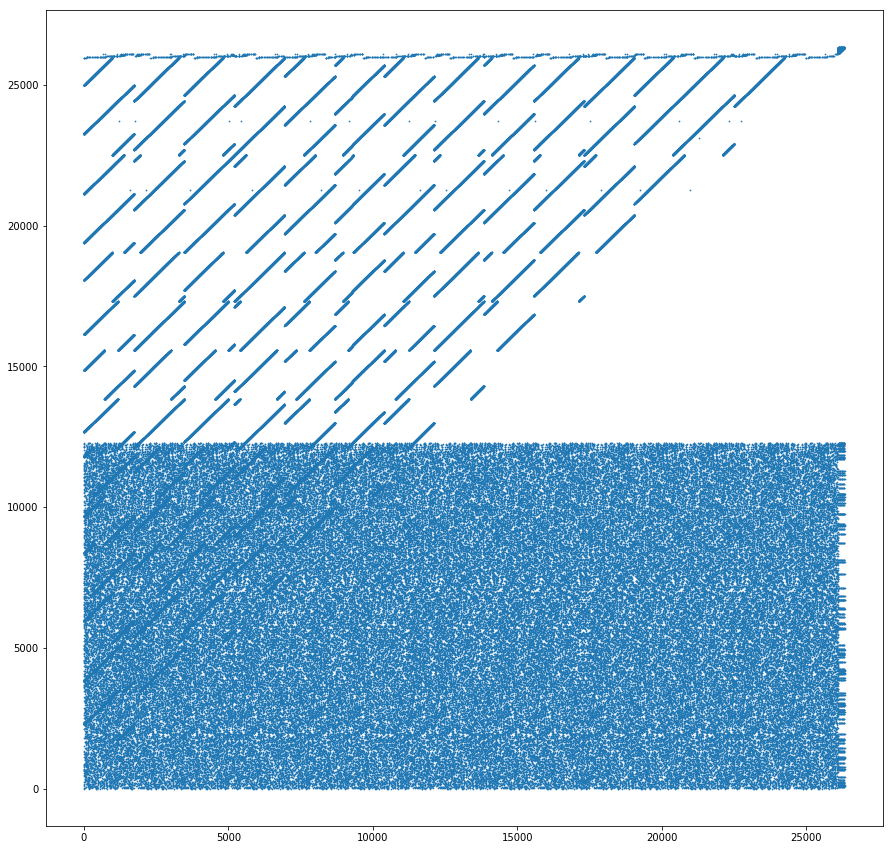

In [94]:
plt.figure(figsize=(15,15))
plt.scatter(test['FirstId'], test['SecondId'], s=.5, cmap=['r', 'b'])
plt.show()

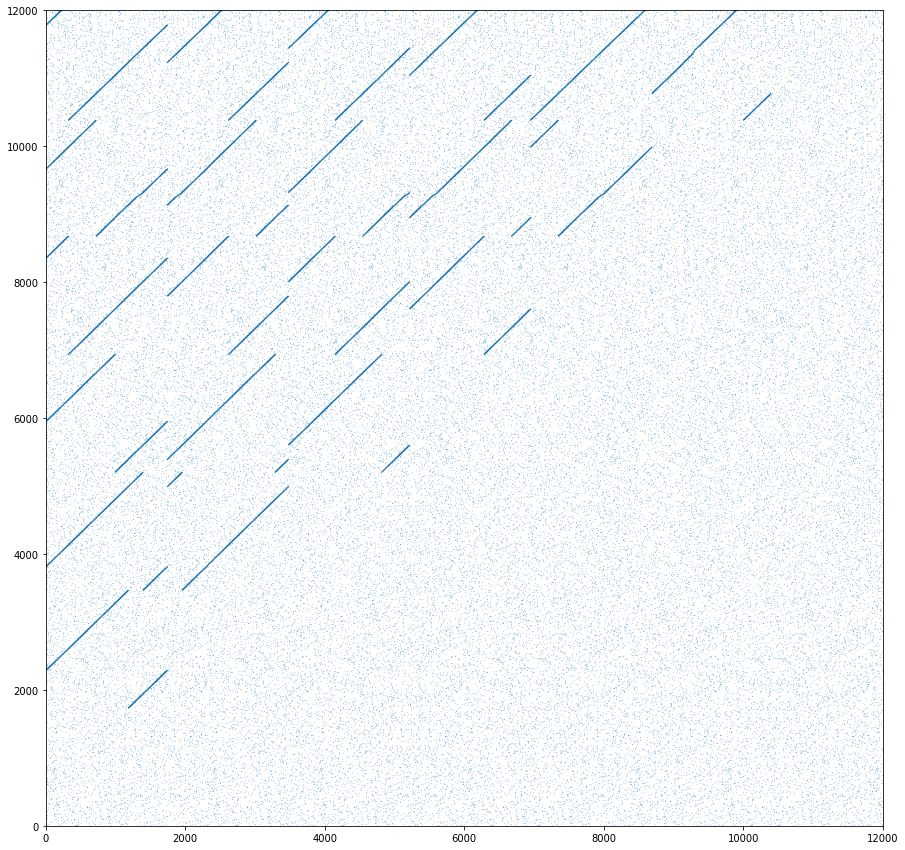

In [130]:
plt.figure(figsize=(15,15))
plt.scatter(test['FirstId'], test['SecondId'], s=.01)
plt.xlim(0, 12000)
plt.ylim(0, 12000)
plt.show()

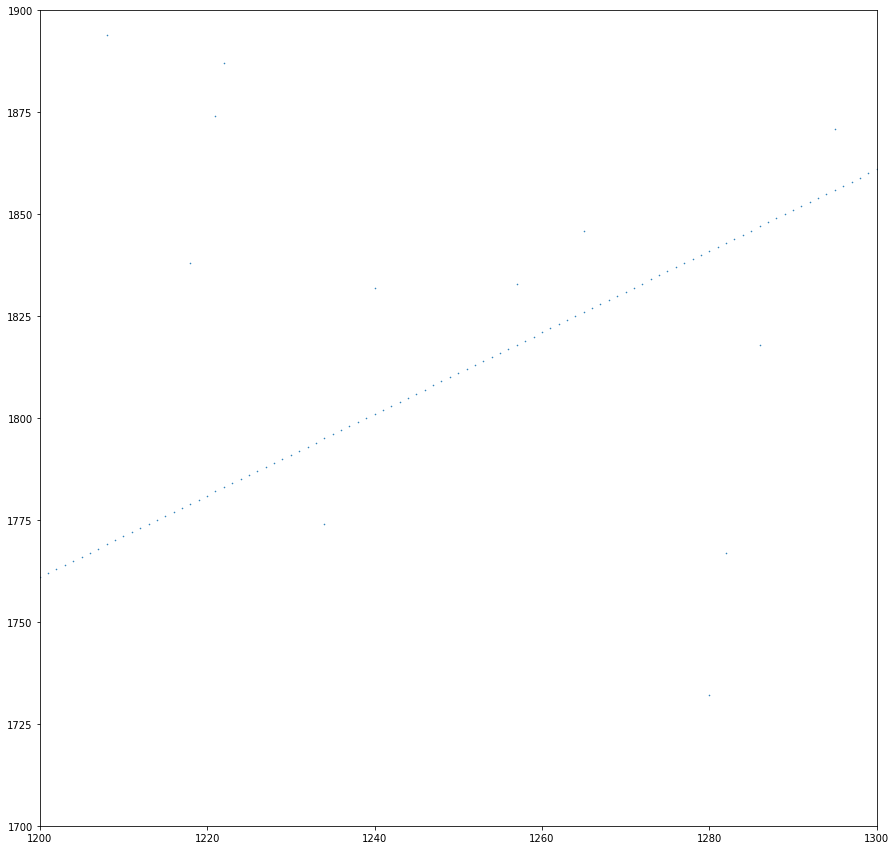

In [147]:
plt.figure(figsize=(15,15))
plt.scatter(test['FirstId'], test['SecondId'], s=.3)
plt.xlim(1200, 1300)
plt.ylim(1700, 1900)
plt.show()

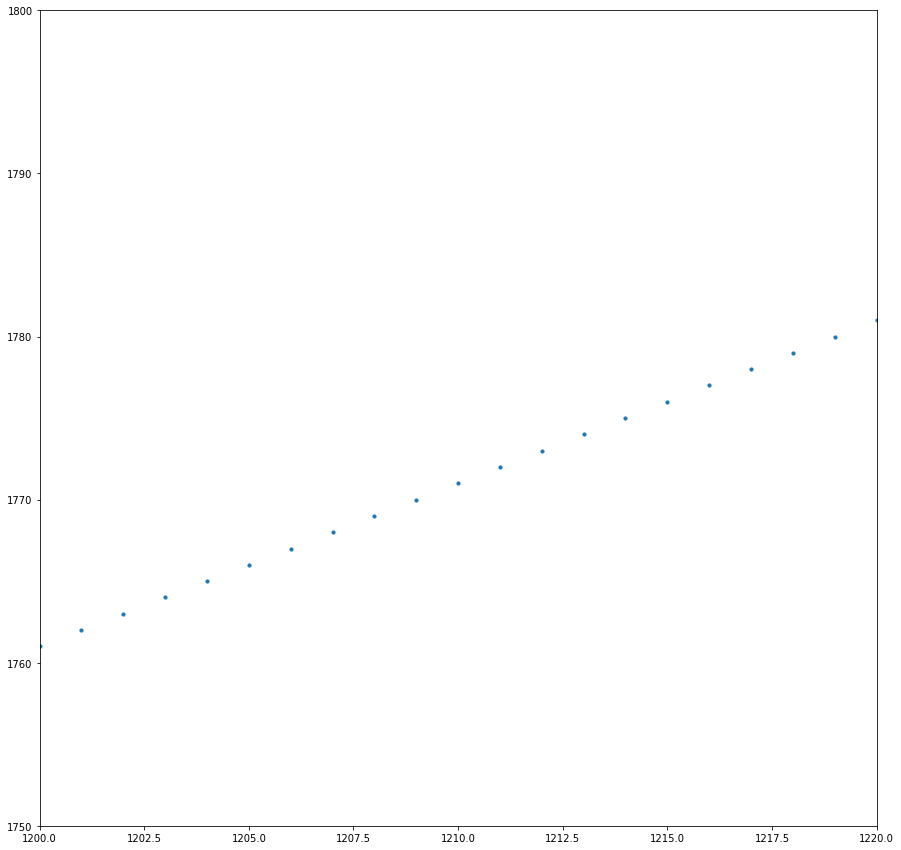

In [152]:
plt.figure(figsize=(15,15))
plt.scatter(test['FirstId'], test['SecondId'], s=10)
plt.xlim(1200, 1220)
plt.ylim(1750, 1800)
plt.show()

## Condition 1. `FirstId` < `SecondId`


In [3]:
first_cond_index = (test['FirstId'] < test['SecondId'])

In [4]:
test['FirstId-SecondId'] = test['FirstId'] - test['SecondId']

In [5]:
first_cond_first_second_diff_vc = test[first_cond_index]['FirstId-SecondId'].value_counts()

In [20]:
test[first_cond_index]['FirstId-SecondId']

0         -6626
2         -1729
3        -12760
5         -8847
6         -4746
9         -1051
10       -10123
11       -11446
12        -7767
14        -6698
17        -3555
19       -20954
21        -2187
23       -14235
24       -10171
25        -7897
28       -11907
29        -9324
30        -3430
33        -8460
38        -4938
41        -8382
42       -17300
43        -2296
44        -3990
47       -14855
49        -6399
50       -10057
51       -13120
52        -5705
          ...  
368510   -12308
368511    -2330
368512   -13120
368513    -3260
368514   -13553
368516     -393
368518   -14392
368519    -8160
368520    -7378
368521   -17833
368522    -8350
368523    -9511
368524    -3461
368526    -6712
368527   -15763
368529    -1528
368530    -1524
368531   -13835
368532   -12308
368533    -4147
368535   -23061
368536   -12097
368538    -3785
368539   -12759
368540   -20955
368542    -6625
368543    -2406
368544   -15763
368545    -3663
368549   -10107
Name: FirstId-SecondId, 

## Condition 2. number of `unique` values of `FirstId-SecondId` column > ` ? `
* Try `500` as threshold value
* Keep experimenting & changing threshold values

In [6]:
first_cond_first_second_diff_vc[first_cond_first_second_diff_vc > 500].sum()

49582

In [7]:
first_cond_first_second_diff_vc[first_cond_first_second_diff_vc > 500].index

Int64Index([ -1730, -14235,  -3717,  -1927,  -5853, -18058,  -2136,  -4330,
             -3823,  -2295, -15763,  -8897,  -1528, -12307, -12099,  -8382,
             -9693, -10124,  -1275,  -6626, -10171, -17295,  -9676,  -6625,
             -7766, -14892,  -5959,  -4993, -21518, -15303, -11433, -21156,
             -6267,  -7381,  -4538, -13435, -11032, -20957,  -7969,  -2802,
             -5179, -12308,  -8848,  -3664,  -6454, -19020, -16130,  -8453,
             -8896,  -9718, -13120, -10172, -23250,  -5586,  -3066,  -7121,
             -6921,   -401, -24979, -15571, -18825, -15163, -22684,  -3203,
            -16319, -13832, -13834, -12560, -14855, -12759, -20955,  -3860,
             -3263,  -3261],
           dtype='int64')

In [8]:
test.head()

,pairId,FirstId,SecondId,FirstId-SecondId
0,0,1427,8053,-6626
1,1,17044,7681,9363
2,2,19237,20966,-1729
3,3,8005,20765,-12760
4,4,16837,599,16238


In [9]:
diffs_in_pattern = first_cond_first_second_diff_vc[first_cond_first_second_diff_vc > 500].index.tolist()
ids_in_pattern = []

for i, diff in enumerate(test['FirstId-SecondId']):
    if diff in diffs_in_pattern:
        ids_in_pattern.append(i)

In [10]:
submit_df = pd.DataFrame({'pairId' : range(len(test))})

In [11]:
submit_df['Prediction'] = np.zeros(len(test))

In [12]:
base_mapping = dict(zip(range(len(test)), np.zeros(len(test))))
for id_ in ids_in_pattern:
    base_mapping[id_] = 1

In [14]:
submit_df['Prediction'] = submit_df['pairId'].map(base_mapping)

In [18]:
submit_df.to_csv('submission.csv', index=False)

### Make a function to create submission file with various thresholds

In [24]:
def make_submission_csv(threshold):
    
    
    diffs_in_pattern = first_cond_first_second_diff_vc[first_cond_first_second_diff_vc > threshold].index.tolist()
    ids_in_pattern = []

    for i, diff in enumerate(test['FirstId-SecondId']):
        if diff in diffs_in_pattern:
            ids_in_pattern.append(i)
    
    base_mapping = dict(zip(range(len(test)), np.zeros(len(test))))
    for id_ in ids_in_pattern:
        base_mapping[id_] = 1
    
    submit_df = pd.DataFrame({'pairId' : range(len(test))})
    submit_df['Prediction'] = submit_df['pairId'].map(base_mapping)
    
    print(submit_df['Prediction'].value_counts())
    
    submit_df.to_csv('submission.csv', index=False)

`submission.csv` download link:
* https://hub.coursera-notebooks.org/user/skrvpncflkmhrekuqsuuab/notebooks/Programming%20assignment%2C%20week%202%3A%20Data%20leakages/submission.csv

In [25]:
# result for threshold 400
# Your accuracy score is 0.683926. It seems too low, try one more time.
make_submission_csv(400)

0.0    300216
1.0     68334
Name: Prediction, dtype: int64


In [26]:
# result for threshold 300
# Your accuracy score is 0.760209. It seems too low, try one more time.
make_submission_csv(300)

0.0    271708
1.0     96842
Name: Prediction, dtype: int64


In [27]:
# result for threshold 100
# Your accuracy score is 0.923758. It seems too low, try one more time.
make_submission_csv(100)

0.0    209542
1.0    159008
Name: Prediction, dtype: int64


In [28]:
# result for threshold 50
# Your accuracy score is 0.967009. It seems too low, try one more time.
make_submission_csv(50)

0.0    192188
1.0    176362
Name: Prediction, dtype: int64


In [29]:
# result for threshold 10
# Your accuracy score is 0.978274. It seems too low, try one more time.
make_submission_csv(10)

1.0    187312
0.0    181238
Name: Prediction, dtype: int64


In [30]:
# result for threshold 2
# Your accuracy score is 0.892177. It seems too low, try one more time.
make_submission_csv(2)

1.0    221571
0.0    146979
Name: Prediction, dtype: int64


In [31]:
make_submission_csv(5)

1.0    205733
0.0    162817
Name: Prediction, dtype: int64


In [32]:
make_submission_csv(8)

1.0    191718
0.0    176832
Name: Prediction, dtype: int64


In [33]:
make_submission_csv(9)

1.0    189072
0.0    179478
Name: Prediction, dtype: int64


In [34]:
make_submission_csv(11)

1.0    186278
0.0    182272
Name: Prediction, dtype: int64


In [35]:
make_submission_csv(12)

1.0    185318
0.0    183232
Name: Prediction, dtype: int64


In [36]:
make_submission_csv(13)

1.0    184863
0.0    183687
Name: Prediction, dtype: int64


In [37]:
make_submission_csv(14)

1.0    184639
0.0    183911
Name: Prediction, dtype: int64


In [38]:
make_submission_csv(15)

1.0    184534
0.0    184016
Name: Prediction, dtype: int64


In [39]:
# result for threshold 16
# Well done! Your accuracy score is 0.983354 
make_submission_csv(16)

1.0    184278
0.0    184272
Name: Prediction, dtype: int64


# EDA and leakage intuition

As we already know, the key to discover data leakages is careful EDA. So let's start our work with some basic data exploration and build an intuition about the leakage.

First, check, how many different `id`s are there: concatenate `FirstId` and `SecondId` and print the number of unique elements. Also print minimum and maximum value for that vector.

In [ ]:
# YOUR CODE GOES HERE

and then print how many pairs we need to classify (it is basically the number of rows in the test set)

In [ ]:
# YOUR CODE GOES HERE

Now print, how many distinct pairs it would be possible to create out of all "images" in the dataset?   

In [ ]:
# YOUR CODE GOES HERE

So the number of pairs we are given to classify is very very small compared to the total number of pairs. 

To exploit the leak we need to **assume (or prove)**, that the total number of positive pairs is small, compared to the total number of pairs. For example: think about an image dataset with $1000$ classes, $N$ images per class. Then if the task was to tell whether a pair of images belongs to the same class or not, we would have $1000\frac{N(N-1)}{2}$ positive pairs, while total number of pairs was $\frac{1000N(1000N - 1)}{2}$.

Another example: in [Quora competitition](https://www.kaggle.com/c/quora-question-pairs) the task was to classify whether a pair of qustions are duplicates of each other or not. Of course, total number of question pairs is very huge, while number of duplicates (positive pairs) is much much smaller.

Finally, let's get a fraction of pairs of class `1`. We just need to submit a constant prediction "all ones" and check the returned accuracy. Create a dataframe with columns `pairId` and `Prediction`, fill it and export it to `.csv` file. Then submit to grader and examine grader's output. 

In [ ]:
# YOUR CODE GOES HERE

So, we assumed the total number of pairs is much higher than the number of positive pairs, but it is not the case for the test set. It means that the test set is constructed not by sampling random pairs, but with a specific sampling algorithm. Pairs of class `1` are oversampled.

Now think, how we can exploit this fact? What is the leak here? If you get it now, you may try to get to the final answer yourself, othewise you can follow the instructions below.   

# Building a magic feature

In this section we will build a magic feature, that will solve the problem almost perfectly. The instructions will lead you to the correct solution, but please, try to explain the purpose of the steps we do to yourself -- it is very important.

## Incidence matrix

First, we need to build an [incidence matrix](https://en.wikipedia.org/wiki/Incidence_matrix). You can think of pairs `(FirstId, SecondId)` as of edges in an undirected graph. 

The incidence matrix is a matrix of size `(maxId + 1, maxId + 1)`, where each row (column) `i` corresponds `i-th` `Id`. In this matrix we put the value `1` to the position `[i, j]`, if and only if a pair `(i, j)` or `(j, i)` is present in  a given set of pais `(FirstId, SecondId)`. All the other elements in the incidence matrix are zeros.   

**Important!** The incidence matrices are typically very very sparse (small number of non-zero values). At the same time incidence matrices are usually huge in terms of total number of elements, and it is **impossible to store them in memory in dense format**. But due to their sparsity incidence matrices **can be easily represented as sparse matrices**. If you are not familiar with sparse matrices, please see [wiki](https://en.wikipedia.org/wiki/Sparse_matrix) and [scipy.sparse reference](https://docs.scipy.org/doc/scipy/reference/sparse.html). Please, use any of `scipy.sparse` constructors to build incidence matrix. 

For example, you can use this constructor: `scipy.sparse.coo_matrix((data, (i, j)))`. We highly recommend to learn to use different `scipy.sparse` constuctors, and matrices types, but if you feel you don't want to use them, you can always build this matrix with a simple `for` loop. You will need first to create a matrix using `scipy.sparse.coo_matrix((M, N), [dtype])` with an appropriate shape `(M, N)` and then iterate through `(FirstId, SecondId)` pairs and fill corresponding elements in matrix with ones. 

**Note**, that the matrix should be symmetric and consist only of zeros and ones. It is a way to check yourself.

In [ ]:
inc_mat = # YOUR CODE GOES HERE (but probably you will need to write few more lines before)

# Sanity checks
assert inc_mat.max() == 1
assert inc_mat.sum() == 736872

It is convenient to have matrix in `csr` format eventually.

In [ ]:
inc_mat = inc_mat.tocsr()

## Now build the magic feature

Why did we build the incidence matrix? We can think of the rows in this matix as of representations for the objects. `i-th` row is a representation for an object with `Id = i`. Then, to measure similarity between two objects we can measure similarity between their representations. And we will see, that such representations are very good.

Now select the rows from the incidence matrix, that correspond to `test.FirstId`'s, and `test.SecondId`'s.

In [ ]:
# Note, scipy goes crazy if a matrix is indexed with pandas' series. 
# So do not forget to convert `pd.series` to `np.array`
# These lines should normally run very quickly 

rows_FirstId   = # YOUR CODE GOES HERE
rows_SecondId  = # YOUR CODE GOES HERE

Our magic feature will be the *dot product* between representations of a pair of objects. Dot product can be regarded as similarity measure -- for our non-negative representations the dot product is close to 0 when the representations are different, and is huge, when representations are similar. 

Now compute dot product between corresponding rows in `rows_FirstId` and `rows_SecondId` matrices.

In [ ]:
# Note, that in order to do pointwise multiplication in scipy.sparse you need to use function `multiply`
# regular `*` corresponds to matrix-matrix multiplication

f = # YOUR CODE GOES HERE

# Sanity check
assert f.shape == (368550, )

That is it! **We've built our magic feature.** 

# From magic feature to binary predictions

But how do we convert this feature into binary predictions? We do not have a train set to learn a model, but we have a piece of information about test set: the baseline accuracy score that you got, when submitting constant. And we also have a very strong considerations about the data generative process, so probably we will be fine even without a training set. 

We may try to choose a thresold, and set the predictions to 1, if the feature value `f` is higer than the threshold, and 0 otherwise. What threshold would you choose? 

How do we find a right threshold? Let's first examine this feature: print frequencies (or counts) of each value in the feature `f`.

In [ ]:
# For example use `np.unique` function, check for flags

print # YOUR CODE GOES HERE

Do you see how this feature clusters the pairs? Maybe you can guess a good threshold by looking at the values? 

In fact, in other situations it can be not that obvious, but in general to pick a threshold you only need to remember the score of your baseline submission and use this information. Do you understand why and how?  

Choose a threshold below: 

In [ ]:
pred = f > # SET THRESHOLD HERE

# Finally, let's create a submission

In [ ]:
submission = test.loc[:,['pairId']]
submission['Prediction'] = pred.astype(int)

submission.to_csv('submission.csv', index=False)

Now submit it to the grader! It is not possible to submit directly from this notebook, as we need to submit a `csv` file, not a single number (limitation of Coursera platform). 

To download `submission.csv` file that you've just produced <a href='./submission.csv'>click here</a> (if the link opens in browser, right-click on it and shoose "Save link as"). Then go to [assignment page](https://www.coursera.org/learn/competitive-data-science/programming/KsASv/data-leakages/submission) and submit your `.csv` file in 'My submission' tab.


If you did everything right, the score should be very high.

**Finally:** try to explain to yourself, why the whole thing worked out. In fact, there is no magic in this feature, and the idea to use rows in the incidence matrix can be intuitively justified.

# Bonus

Interestingly, it is not the only leak in this dataset. There is another totally different way to get almost 100% accuracy. Try to find it!